# Supply Chain 101 revisited with Modern Bayesian Techniques (Draft Outline)

Companies want to have stock on hand to sell you, but they don't want to buy stuff they won't sell. How do you figure out how much to hold a buy?

Step 1: Estimate supply lead times and demand levels

To know how much we need to order, and when, we need use a basic formula
* Daily_Demand * Lead Time in days

So for example if you sell ten boxes of cereal a day, and it takes 3 days for orders to arrive from the cereal fatory, then you should hold 30 boxes of cereal on hand or you'll run out as people buy their breakfast.

This is great except in real life, both demand and supply are not constant. 
In most textbook this is either given, or done through point estimates. With Pymc3 we can do way better

## Step 1: Collect Data
Data in supply chains usually is just transactions in a SQL Database. These need to be converted into distributions for Pymc3

In [1]:
import numpy as np
import pymc3 as pm

In [2]:
# This usually needs to be calculated as well
supplier_leadtime_days = np.repeat([2,4,2,3,2,2,3], 10)*10
demand_per_day = np.repeat([2,4,2,3,2,2,3], 10)

## Step 2: Estimate Distributions
Good thing we have Bayesian Magic.

Poisson is a good choice because it only exists over domain of positive natural numbers. Demand rarely is fractional (depends on industry and product though). Lead time is usually planned in days between suppliers. 

In [3]:
with pm.Model() as supplier_lead_time:
    # Just guessing on the priors
    _lambda = pm.Normal("lambda", mu=10, sd=2)
    lead_time = pm.Poisson("lead_time", mu=_lambda, observed = supplier_leadtime_days)
    posterior = pm.sample()
    posterior_pred = pm.sample_posterior_predictive(posterior)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:01<00:00, 1611.26draws/s]
The acceptance probability does not match the target. It is 0.891421801468484, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8877590191837893, but should be close to 0.8. Try to increase the number of tuning steps.
100%|██████████| 500/500 [00:00<00:00, 2412.94it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c22c11048>],
      dtype=object)

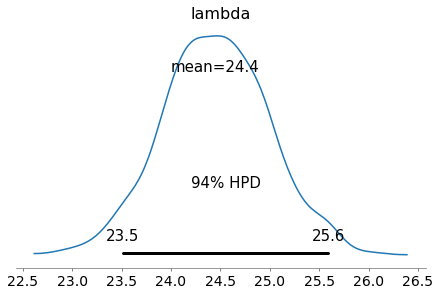

In [4]:
import arviz as az
az.plot_posterior(posterior)

### Also estimate demand distribution

## Step 3: Using two distributions, generate demand over supply lead time distribution
Procedure
1. Take random sample from LT Distribution to achieve lead_time_days
2. Take N samples from demand distribution, where N=lead_time_days
3. Add sample to demand_over_lt  sample
4. Repeat until you have large sample set

Now a choice
Use non parameteric to determine 95% distribution bounds, or use Pymc3 to estimate distribution parameters

This is already way better than what most supply chains do so doesn't have to be perfectb

## Extending this
1. Demand can be estimated with anything, Arima, Prophet, take your pick
2. I think there's a clever way to incoporate existing orders into risk as well. Need to think through this more, might be another blog post